In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from opacus.utils.batch_memory_manager import BatchMemoryManager
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, AdamW
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from opacus import PrivacyEngine
from torch.nn.utils.rnn import pad_sequence

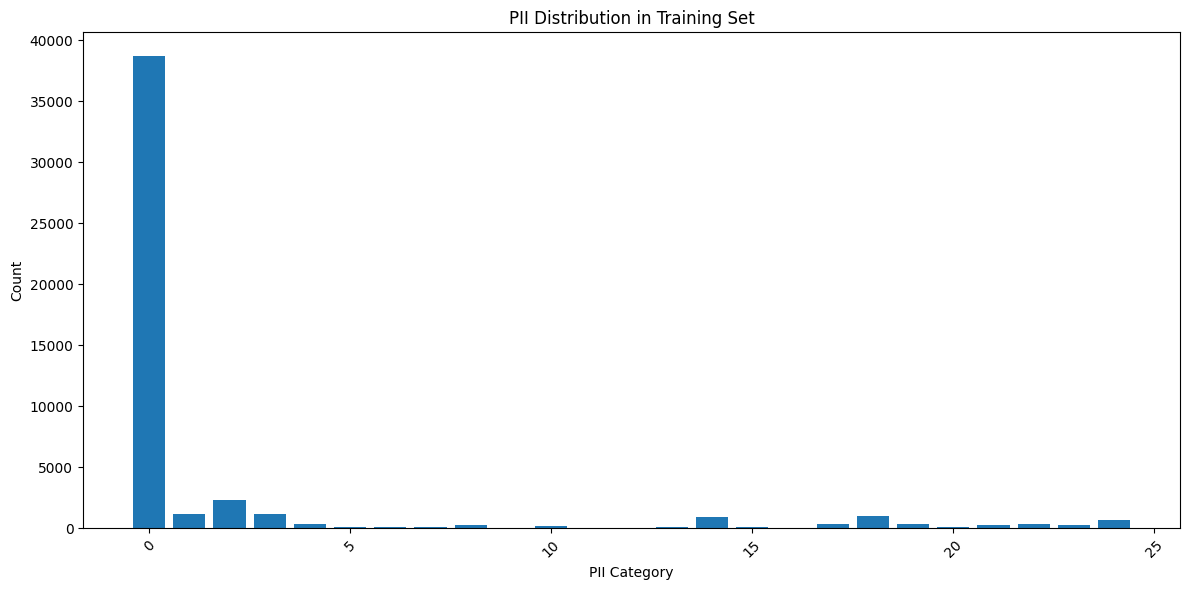

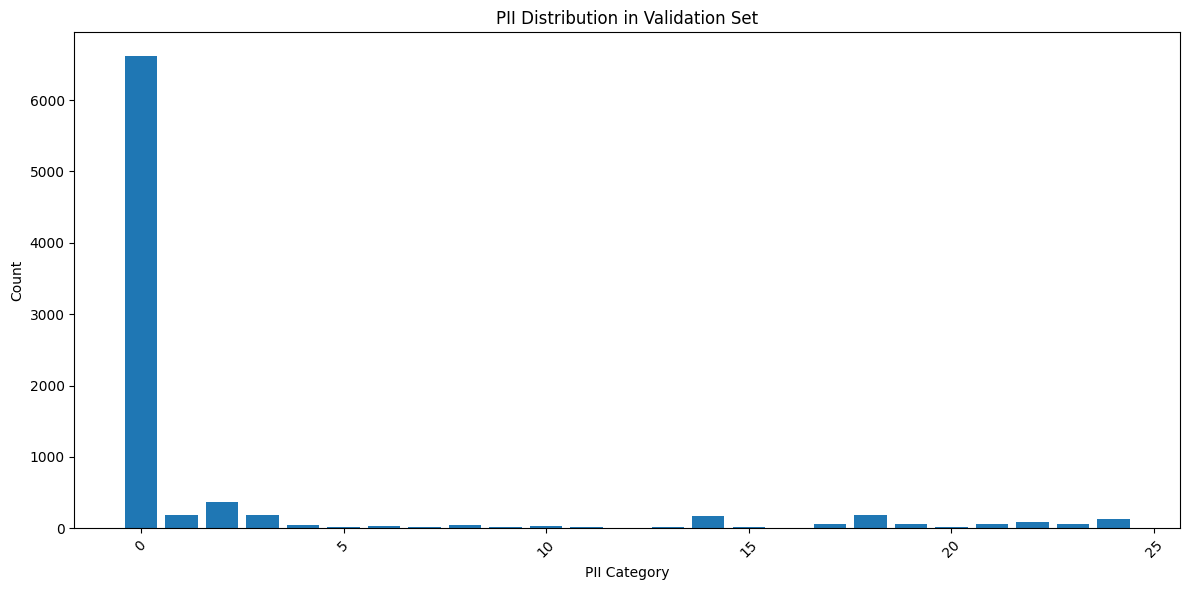

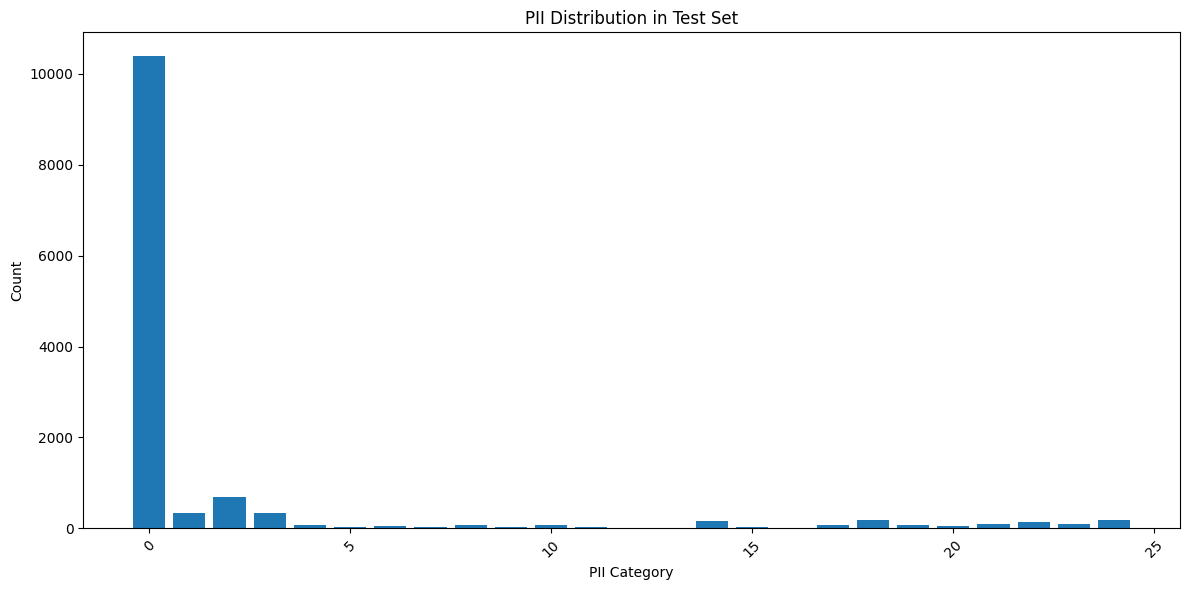

Dataset Statistics:
Total samples: 2979
Training samples: 2085
Validation samples: 358
Test samples: 536


In [2]:
# Data Preparation and Analysis
def load_and_analyze_data():
    dataset = load_dataset("Conrad747/lg-ner")
    
    def analyze_pii_distribution(dataset):
        pii_counts = Counter()
        for example in dataset:
            pii_counts.update(example['ner_tags'])
        return pii_counts

    train_pii_dist = analyze_pii_distribution(dataset['train'])
    val_pii_dist = analyze_pii_distribution(dataset['validation'])
    test_pii_dist = analyze_pii_distribution(dataset['test'])

    def plot_pii_distribution(pii_dist, title):
        plt.figure(figsize=(12, 6))
        plt.bar(pii_dist.keys(), pii_dist.values())
        plt.title(title)
        plt.xlabel('PII Category')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    plot_pii_distribution(train_pii_dist, 'PII Distribution in Training Set')
    plot_pii_distribution(val_pii_dist, 'PII Distribution in Validation Set')
    plot_pii_distribution(test_pii_dist, 'PII Distribution in Test Set')

    print(f"Dataset Statistics:")
    print(f"Total samples: {len(dataset['train']) + len(dataset['validation']) + len(dataset['test'])}")
    print(f"Training samples: {len(dataset['train'])}")
    print(f"Validation samples: {len(dataset['validation'])}")
    print(f"Test samples: {len(dataset['test'])}")

    return dataset

dataset = load_and_analyze_data()


In [3]:
#Tokenization and Data Preparation
def tokenize_and_align_labels(examples, tokenizer, max_length=128):
    tokenized_inputs = tokenizer(
        examples["tokens"], 
        truncation=True, 
        is_split_into_words=True, 
        padding='max_length',  
        max_length=max_length  
    )
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

def prepare_data(dataset):
    tokenizer = AutoTokenizer.from_pretrained("Conrad747/luganda-ner-v6")
    tokenized_datasets = dataset.map(tokenize_and_align_labels, fn_kwargs={"tokenizer": tokenizer}, batched=True)
    
    tokenized_datasets = tokenized_datasets.remove_columns(["tokens", "ner_tags", "id"])
    tokenized_datasets.set_format("torch")
    
    return tokenized_datasets, tokenizer

tokenized_datasets, tokenizer = prepare_data(dataset)


In [10]:
#Dataloader Creation
def custom_collate_fn(batch):
    input_ids = pad_sequence([b['input_ids'] for b in batch], batch_first=True)
    attention_mask = pad_sequence([b['attention_mask'] for b in batch], batch_first=True)
    labels = pad_sequence([b['labels'] for b in batch], batch_first=True, padding_value=-100)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

def create_dataloaders(tokenized_datasets, batch_size=16):
    train_dataloader = DataLoader(
        tokenized_datasets["train"], 
        shuffle=True, 
        batch_size=batch_size, 
        collate_fn=custom_collate_fn
    )
    eval_dataloader = DataLoader(
        tokenized_datasets["validation"], 
        batch_size=batch_size, 
        collate_fn=custom_collate_fn
    )
    test_dataloader = DataLoader(
        tokenized_datasets["test"], 
        batch_size=batch_size, 
        collate_fn=custom_collate_fn
    )
    return train_dataloader, eval_dataloader, test_dataloader

train_dataloader, eval_dataloader, test_dataloader = create_dataloaders(tokenized_datasets, batch_size=16)


In [11]:
#Differential Privacy Setup
def setup_privacy_engine(model, optimizer, data_loader, max_grad_norm, noise_multiplier, target_delta):
    privacy_engine = PrivacyEngine()

    model.train()  # Set model to training mode before applying the privacy engine

    model, optimizer, data_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=data_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=max_grad_norm,
    )

    return model, optimizer, data_loader, privacy_engine


In [13]:
#Model Initialization
def initialize_model_and_optimizer():
    model = AutoModelForTokenClassification.from_pretrained("Conrad747/luganda-ner-v6").to(device)
    optimizer = AdamW(model.parameters(), lr=5e-5)
    return model, optimizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
#Model Training
def train_model(model, train_dataloader, eval_dataloader, optimizer, device, num_epochs=5, privacy_engine=None):
    for epoch in range(num_epochs):
        model.train()

        with BatchMemoryManager(
            data_loader=train_dataloader, 
            max_physical_batch_size=1,  
            optimizer=optimizer
        ) as memory_safe_data_loader:
            for batch in memory_safe_data_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

        model.eval()
        eval_loss = 0
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            eval_loss += outputs.loss.item()
        eval_loss /= len(eval_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} - Eval Loss: {eval_loss:.4f}")

    if privacy_engine:
        epsilon = privacy_engine.get_epsilon(delta=1e-5)
        print(f"Final Epsilon after training: {epsilon:.2f}")


In [15]:
#Model Evaluation
def evaluate_model(model, test_dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=2)
        predictions.extend(pred.cpu().numpy().flatten())
        true_labels.extend(batch["labels"].cpu().numpy().flatten())
    
    predictions = [p for p, l in zip(predictions, true_labels) if l != -100]
    true_labels = [l for l in true_labels if l != -100]
    
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    return precision, recall, f1


In [ ]:
# Better Privacy model
model_2, optimizer_2 = initialize_model_and_optimizer()
model_2, optimizer_2, train_dataloader_2, privacy_engine_2 = setup_privacy_engine(
    model_2, optimizer_2, train_dataloader,
    max_grad_norm=0.5, noise_multiplier=2.0, target_delta=1e-4
)

print("Training model: Better Privacy")
train_model(model_2, train_dataloader_2, eval_dataloader, optimizer_2, device, privacy_engine=privacy_engine_2)
precision_2, recall_2, f1_2 = evaluate_model(model_2, test_dataloader, device)

print(f"Model Better Privacy - Precision: {precision_2:.4f}, Recall: {recall_2:.4f}, F1 Score: {f1_2:.4f}")


Training model: Better Privacy
Epoch 1/5 - Eval Loss: 0.2430
Epoch 2/5 - Eval Loss: 0.2461
Epoch 3/5 - Eval Loss: 0.2452
